### <ins>Métricas: </uns>

Tenemos dos objetivos:

- Analizar las métricas durante el entrenamiento.
- Analizar las métricas para el test, comparando los GoL de los tableros predichos con el tablero final real. 

A priori, el analizar todas las métricas para los GoL puede parecer un poco inutil. Sin embargo, creo que puede ser de gran interés de cara a saber la performace real de nuestro modelo en tema predecir tableros iniciales que lleven al tablero final real.

#### 1. **Importamos librerías y cargamos los historiales**

Además, vamos a definir las funciones que usamos en el entrenamiento para ser consistentes.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import tensorflow as tf
from keras.models import load_model
from sklearn.metrics import (precision_score, recall_score, f1_score, confusion_matrix, hamming_loss)
from keras import backend as K

# 1. Define la semilla
SEED = 42  # Según ChatGPT es la mejor
 
# 2. Python built-in random
random.seed(SEED)

# 3. NumPy
np.random.seed(SEED)

# 4. TensorFlow
tf.random.set_seed(SEED)

# (Opcional) Para TensorFlow más determinismo en operaciones GPU:
os.environ['TF_DETERMINISTIC_OPS'] = '1'


def recall(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    tp = K.sum(y_true * y_pred_pos)
    possible_positives = K.sum(y_true)
    return tp / (possible_positives + K.epsilon())

def precision(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    tp = K.sum(y_true * y_pred_pos)
    predicted_positives = K.sum(y_pred_pos)
    return tp / (predicted_positives + K.epsilon())

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec + K.epsilon())

def specificity(y_true, y_pred):
    y_pred_neg = 1 - K.round(K.clip(y_pred, 0, 1))
    y_true_neg = 1 - y_true
    tn = K.sum(y_true_neg * y_pred_neg)
    possible_negatives = K.sum(y_true_neg)
    return tn / (possible_negatives + K.epsilon())

def hamming_loss(y_true, y_pred):
    mismatches = K.not_equal(K.round(K.clip(y_pred, 0, 1)), y_true)
    return K.mean(K.cast(mismatches, K.floatx()))

In [2]:
historiales_delta = {}
# Iteramos de 1 a 2 porque solo tenemos un modelo entrenado
for i in range(1, 2):
    # Formateamos el string del path según el valor de i
    path = f"../../Modelo GoL/Historiales/historial_delta_{i}_FBCE.xlsx"
    historiales_delta[f"historial_delta_{i}_FBCE"] = pd.read_excel(path, header=0)

path = "../../Datos"
datos = []
for dirnames,_,filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('.xlsx'):
            datos.append(os.path.join(dirnames,filename))

print(datos)

['../../Datos\\test.xlsx', '../../Datos\\train.xlsx']


#### 2. **Métricas del entrenamiento:**

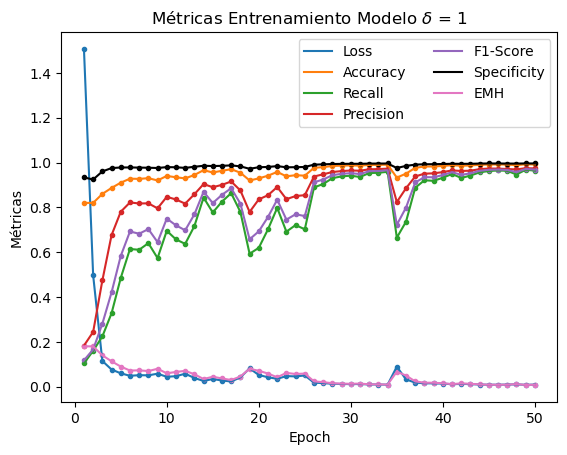

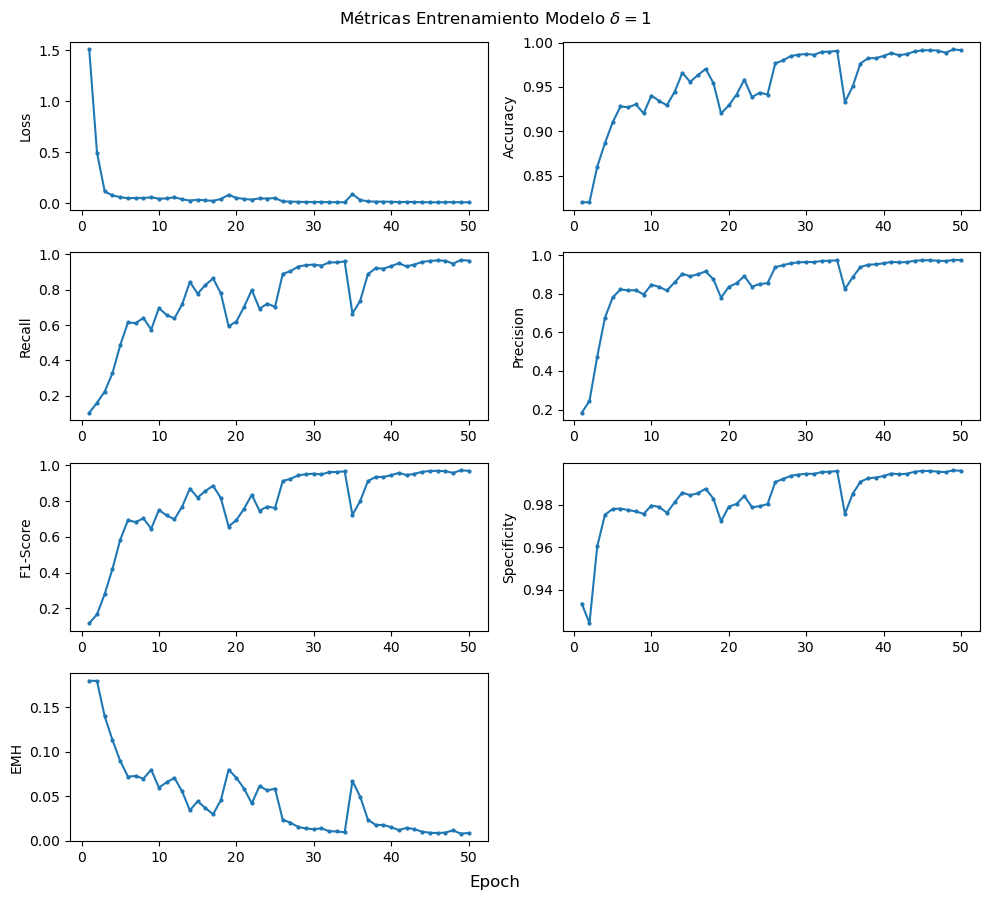

----------------------------------------------------------------------------------------


In [3]:
ylabels = ['Loss', 'Accuracy', 'Recall', 'Precision', 'F1-Score', 'Specificity', 'EMH']
headers = ['loss', 'predicted_final_accuracy', 'predicted_final_recall', 'predicted_final_precision', 'predicted_final_f1_score', 'predicted_final_specificity', 'predicted_final_hamming_loss']
colores = ['#1f77b4',  # Azul
          '#ff7f0e',  # Naranja
          '#2ca02c',  # Verde
          '#d62728',  # Rojo
          '#9467bd',  # Púrpura
          'black',  # Marrón claro
          '#e377c2']  # Rosa fuerte


for delta in range(1, 2):

    key = f'historial_delta_{delta}_FBCE'

### PLOT
    fig = plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Métricas')
    plt.title(fr'Métricas Entrenamiento Modelo $\delta$ = {delta}')

    for i in range(len(ylabels)):

        y = historiales_delta[key][headers[i]] 
        x = np.arange(1, len(y)+1)

        plt.plot(x,y, color = colores[i], label = ylabels[i])
        plt.scatter(x,y, color = colores[i], s= 9 )

    plt.legend(ncol=2, loc='upper right')
    fig.savefig(f'../../Modelo GoL/Resultados/Métricas Entrenamiento/Juntas/metricas{delta}_FBCE.png', dpi=300, bbox_inches='tight')
### SUBPLOT
    fig, ax = plt.subplots(4, 2, figsize=(10, 10))
    ax = ax.flatten()


    for i in range(len(ylabels)):

        y = historiales_delta[key][headers[i]]
        x = np.arange(1, len(y)+1)

        ax[i].plot(x, y)
        ax[i].scatter(x, y, s=4)
        ax[i].set_ylabel(ylabels[i])
    
    
    # Desactivar el último subplot (esquina inferior derecha) para que no salga en blanco
    fig.delaxes(ax[-1])

    fig.suptitle(fr'Métricas Entrenamiento Modelo $\delta = ${delta}', y=0.93)
    fig.supxlabel('Epoch', y=0.05)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajuste para que no se solape título
    fig.savefig(f'../../Modelo GoL/Resultados/Métricas Entrenamiento/Separadas/metrica{delta}_FBCE.png', dpi=300, bbox_inches='tight')

    plt.show()
    print('----------------------------------------------------------------------------------------')

#### 3. **Métricas Predicciones:**

In [4]:
test = pd.read_excel((datos[0]), sheet_name = 'test', header = 0)


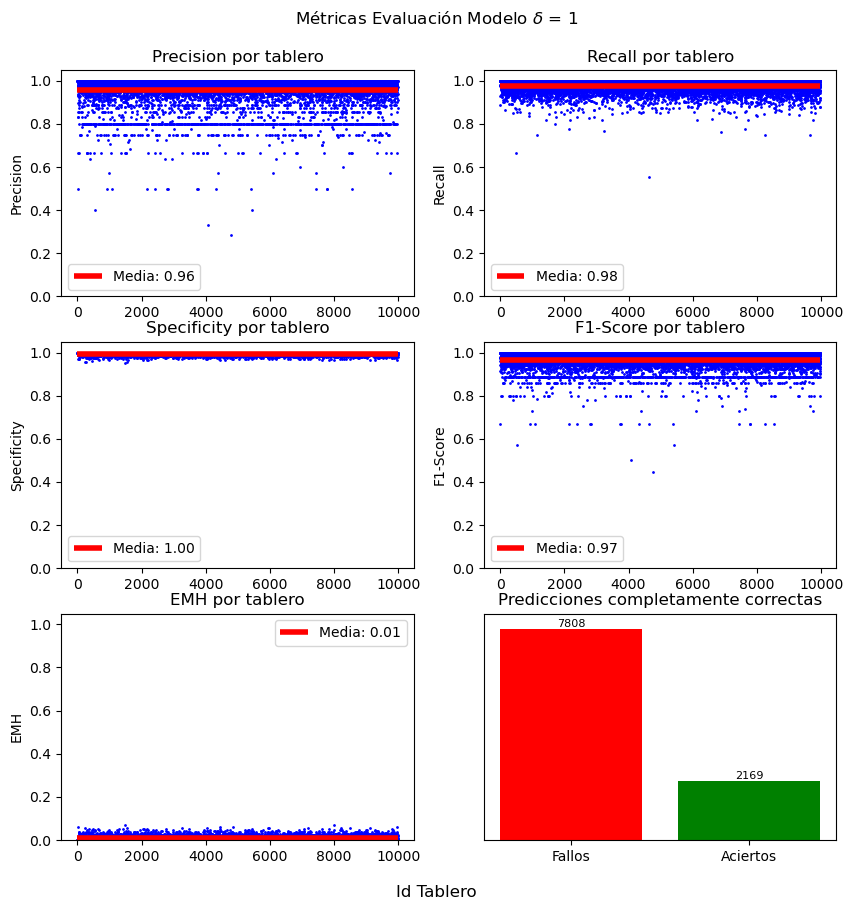

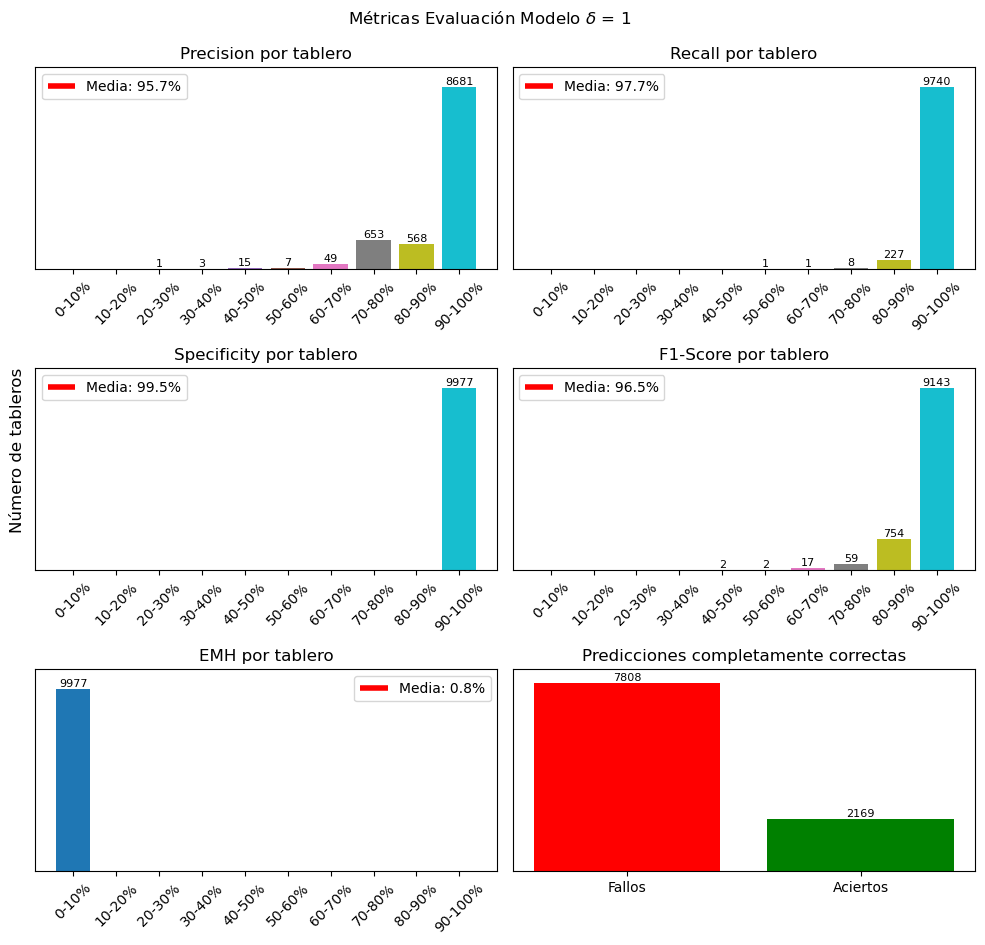

In [5]:
stops = [f'stop.{i}' for i in range(1,401)]
stops2 = [f'stop_{i}' for i in range(0,400)]
for delta in range(1,2):

    key = f'delta_{delta}'

    df_predicciones = pd.read_excel('predicciones_FBCE.xlsx', sheet_name=key, header=0, usecols=stops2)
    numpy_pred = df_predicciones.to_numpy() # shape (n_tableros, 400)
    tableros_finales_pred = numpy_pred.reshape(-1,20,20) # shape (n_tableros, 20, 20)
    
    delta_i = test[test['delta'] == delta]
    finales_i = np.reshape(delta_i[stops].values, (-1,20,20), order='F')  # shape (n_tableros_finales, 20,20)
    
    ### Métricas ###

    precisiones = []
    sensibilidades = []
    F1_scores      = []
    especificidades = []
    hammings = []
    absolutos = []

    for tablero_final_pred, final_real in zip(tableros_finales_pred, finales_i):  # (20x20), (20x20)

        # Hay que usar ravel porque los comandos de las métricas esperan valores, no arrays
        y_pred = tablero_final_pred.astype(int).ravel()  # (20x20) => (400,)
        y_true = final_real.astype(int).ravel()  # (20x20) => (400,)

        # Convertir a tensores float32
        y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
        y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)

        precisiones.append(precision(y_true, y_pred).numpy())
        sensibilidades.append(recall(y_true, y_pred).numpy())
        F1_scores.append(f1_score(y_true, y_pred).numpy())
        especificidades.append(specificity(y_true, y_pred).numpy())
        hammings.append(hamming_loss(y_true, y_pred).numpy())
        absolutos.append(np.array_equal(y_pred, y_true))

    ### Gráficas puntos ###
    
    id = np.arange(0, len(tableros_finales_pred)) # id de los tableros
   
    fallos = absolutos.count(0)
    aciertos = absolutos.count(1)

    lista = [precisiones, sensibilidades, especificidades, F1_scores, hammings, absolutos]
    metricas = ['Precision', 'Recall', 'Specificity', 'F1-Score', 'EMH', 'Absoluto']

    xlab = ['Fallos', 'Aciertos']
    barras_conteo = [fallos, aciertos]
    color_conteo = ['red', 'green']

    fig, ax = plt.subplots(3, 2, figsize=(10,10))
    ax = ax.flatten()

    for k in range(len(metricas)):

        if k != len(metricas) - 1:
            ax[k].scatter(id, lista[k], s=1, color ='blue')  
            ax[k].set_ylim(0,1.05)
            ax[k].set_title(f'{metricas[k]} por tablero') 
            ax[k].set_ylabel(metricas[k])
            ax[k].hlines(np.mean(lista[k]), 0, id[-1], color='red', linewidth=4, label = f'Media: {np.mean(lista[k]):.2f}')
            ax[k].legend(loc='best')
        else:
            for i in range(2):
                ax[k].bar(x = xlab[i], height = barras_conteo[i], color= color_conteo[i])
                ax[k].annotate(f'{barras_conteo[i]}', xy=(xlab[i], barras_conteo[i]), ha='center', va='bottom', fontsize=8, color='black')

            ax[k].set_title('Predicciones completamente correctas')
            ax[k].set_yticks([])
            ax[k].set_ylim(0, max(barras_conteo)*1.075)
    
    fig.suptitle(fr'Métricas Evaluación Modelo $\delta$ = {delta}', y = 0.94)
    fig.supxlabel('Id Tablero', y=0.05)
    fig.savefig(f'../../Modelo GoL/Resultados/Métricas Test/Distribuciones/distribucion{delta}_FBCE.png', dpi=300, bbox_inches='tight')
    
    fig, ax = plt.subplots(3, 2, figsize=(10,10))
    ax = ax.flatten()

    x = ['0-10%', '10-20%', '20-30%', '30-40%','40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

    for k in range(len(metricas)):
        
        contados_x_intervalos = []

        if k != len(metricas) - 1:
            ax[k].hlines(np.mean(lista[k])*100, 0,0, color='red', linewidth=4, label = f'Media: {np.round(np.mean(lista[k])*100,1)}%')
            ax[k].legend(loc='best')
            for i in np.arange(0, 1, 0.1):
                x1 = i
                x2 = i + 0.1
                if i == 0.0:
                    contados_x_intervalos.append(np.sum((lista[k] >= x1) & (lista[k] <= x2)))
                else:
                    contados_x_intervalos.append(np.sum((lista[k] > x1) & (lista[k] <= x2)))

            
                    ### Gráficos de Barras ###

            colores = ['#1f77b4',  # azul
                        '#ff7f0e',  # naranja
                        '#2ca02c',  # verde
                        '#d62728',  # rojo
                        '#9467bd',  # morado
                        '#8c564b',  # marrón
                        '#e377c2',  # rosa
                        '#7f7f7f',  # gris
                        '#bcbd22',  # verde amarillento
                        '#17becf']  # azul verdoso
            
            
            for j in range(0, len(contados_x_intervalos)):
                
                real = contados_x_intervalos[j]
                
                y = real/len(id)
                
                if real< 1000:
                    if real == 0:

                        ax[k].bar(x[j], y, color='black')

                    elif real < 100:

                        ax[k].bar(x[j], y*5,color = colores[j])
                        ax[k].annotate(f'{contados_x_intervalos[j]}', xy=(x[j], y*5), ha='center', va='bottom', fontsize=8, color='black')
                        
                        
                    else:
                        ax[k].bar(x[j], y*2,color = colores[j])
                        ax[k].annotate(f'{contados_x_intervalos[j]}', xy=(x[j], y*2), ha='center', va='bottom', fontsize=8, color='black')
                        

                else:
                    
                    ax[k].bar(x[j],y*0.95, color = colores[j])
                    ax[k].annotate(f'{contados_x_intervalos[j]}', xy=(x[j], y*0.95), ha='center', va='bottom', fontsize=8, color='black')

                ax[k].set_yticks([])
                ax[k].set_ylim(0, (max(contados_x_intervalos))/len(id)*1.05)
                ax[k].set_title(f'{metricas[k]} por tablero')
                ax[k].tick_params(axis='x', rotation=45) 

        else:
            for i in range(2):
                ax[k].bar(x = xlab[i], height = barras_conteo[i], color= color_conteo[i])
                ax[k].annotate(f'{barras_conteo[i]}', xy=(xlab[i], barras_conteo[i]), ha='center', va='bottom', fontsize=8, color='black')

            ax[k].set_title('Predicciones completamente correctas')
            ax[k].set_yticks([])
            ax[k].set_ylim(0, max(barras_conteo)*1.075)

    # fig.delaxes(ax[-1])
    fig.supylabel('Número de tableros')
    fig.suptitle(fr'Métricas Evaluación Modelo $\delta$ = 1', y = 0.94)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    fig.savefig(f'../../Modelo GoL/Resultados/Métricas Test/Barras/barras{delta}_FBCE.png', dpi=300, bbox_inches='tight')
    
plt.show()

#### 4. **Comparativa:**
Plot de algunos tableros para comparar.


----------------------------------------------------------------------------------------


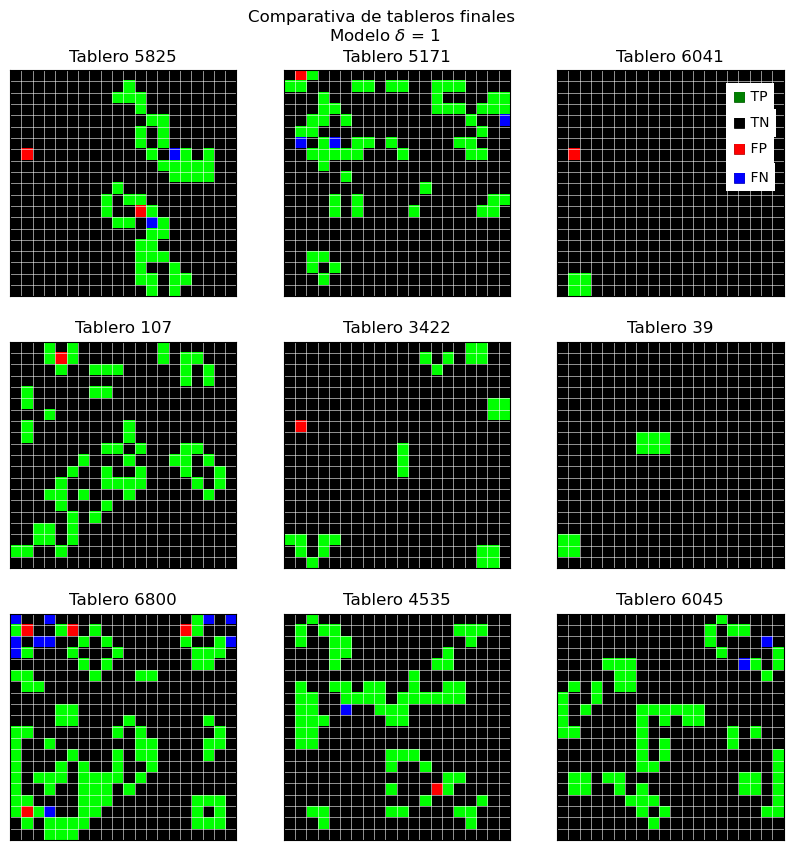

In [6]:
for delta in range(1,2):

    key = f'delta_{delta}'

    # Leer todo el sheet del delta
    df_predicciones = pd.read_excel('predicciones_FBCE.xlsx', sheet_name=key, header=0, usecols=stops2)

    # Filtro los datos del test asociados a esta delta:
    delta_i = test[test['delta'] == delta]

    # Definir índices aleatorios comunes
    n_filas = len(delta_i)
    indices_aleatorios = np.random.RandomState(seed=42).choice(n_filas, size=9, replace=False)

    # Seleccionar filas específicas
    df_muestra = df_predicciones.iloc[indices_aleatorios]
    delta_muestra = delta_i.iloc[indices_aleatorios]

    # Pasar a NumPy
    numpy_pred = df_muestra.to_numpy()  # shape (10, 400)
    tableros_finales_pred = numpy_pred.reshape(-1, 20, 20)  # shape (10, 20, 20)

    finales_i = np.reshape(delta_muestra[stops].values, (-1, 20, 20, 1), order='F')

    fig, axes = plt.subplots(3,3, figsize=(10,10))
    fig.suptitle('Comparativa de tableros finales \n' fr'Modelo $\delta$ = {delta}', y=0.94)
    axes = axes.flatten()
    axes[2].text(15, 2.2, '\u25A0 TP', color='black', fontsize=10, bbox={'facecolor': 'white', 'pad': 5,'edgecolor': 'none'})
    axes[2].text(15, 2.2, '\u25A0', color='green', fontsize=10) 

    axes[2].text(15, 4.5, '\u25A0 TN', color='black', fontsize=10,
             bbox={'facecolor': 'white', 'pad': 5,'edgecolor': 'none'}) 
    axes[2].text(15, 4.5, '\u25A0', color='black', fontsize=10)
    
    axes[2].text(15, 6.8, '\u25A0 FP', color='black', fontsize=10,
             bbox={'facecolor': 'white', 'pad': 5,'edgecolor': 'none'})
    axes[2].text(15, 6.8, '\u25A0', color='red', fontsize=10)
   
    axes[2].text(15, 9.3, '\u25A0 FN', color='black', fontsize=10,
             bbox={'facecolor': 'white', 'pad': 5,'edgecolor': 'none'})
    axes[2].text(15, 9.3, '\u25A0', color='blue', fontsize=10)
    
    
    i = 0
    for final, y_real in zip(tableros_finales_pred, finales_i):
         y_real = y_real.reshape(20,20)
         y_pred = final.reshape(20,20)

         comparativa = np.zeros((20,20,3))
        # Criterio de colores:

         comparativa[(y_real == 1) & (y_pred == 1)] = [0,1,0]  # Si coinciden, verde (TP)
         comparativa[(y_real == 0) & (y_pred == 0)] = [0,0,0]  # Si coinciden, negro (TN)
         comparativa[(y_real == 0) & (y_pred == 1)] = [1,0,0]  # Muerto pero vivo, azul (FP)
         comparativa[(y_real == 1) & (y_pred == 0)] = [0,0,1]  # Vivo pero muerto, rojo (FN)
         axes[i].imshow(comparativa)
         axes[i].set_xticks([])
         axes[i].set_yticks([])
         axes[i].set_title(f'Tablero {indices_aleatorios[i]}')
         

         # Añadir mallado
         axes[i].set_xticks(np.arange(-0.5, 20, 1), minor=True)
         axes[i].set_yticks(np.arange(-0.5, 20, 1), minor=True)
         axes[i].grid(which='minor', color='white', linestyle='-', linewidth=0.4)

         # Eliminar totalmente las etiquetas de los ticks (sin numeritos, sin marcas)
         axes[i].tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
          # Quitar los ticks mayores y menores (solo deja la grid)
         axes[i].set_xticks([])
         axes[i].set_yticks([])
    
         i +=1
    fig.savefig(f'../../Modelo GoL/Resultados/Comparativa/comparativa{delta}_FBCE.png', dpi=300, bbox_inches='tight')
    print('----------------------------------------------------------------------------------------')
    plt.show()